In [ ]:
!pip install numpy seaborn tqdm

In [8]:
import polars as pl
import hashlib
import random 
import numpy as np
from steganodf.algorithms import BitPool
from reedsolo import RSCodec
import seaborn as sns
import statistics
import matplotlib.pyplot as plt
import string
from tqdm import tqdm
import concurrent.futures
%load_ext autoreload
%autoreload 2

## Chargement du dataset

In [9]:
df = pl.read_csv("heart_attack_predictions.csv")
df

Country,Age,Gender,Cholesterol_Level,Blood_Pressure,Smoking_History,Alcohol_Consumption,Physical_Activity,Obesity,Diabetes,Family_History,Stress_Levels,Dietary_Habits,Heart_Attack_History,Chest_Pain,Exercise_Induced_Angina,Resting_ECG,Max_Heart_Rate_Achieved,Thalassemia,HDL_Cholesterol,LDL_Cholesterol,Triglycerides,Heart_Disease_Risk,Medication_Adherence,Urbanization_Level,Air_Pollution_Exposure,Access_To_Healthcare,Education_Level,Income_Level,Heart_Attack_Outcome
str,i64,str,f64,f64,str,f64,str,str,str,str,f64,str,str,str,str,str,i64,str,f64,f64,f64,str,str,str,f64,str,str,str,str
"""Germany""",39,"""Male""",210.091036,173.30165,"""Never""",0.531933,"""Active""","""No""","""No""","""Yes""",3.559035,"""Healthy""","""Yes""","""Yes""","""Yes""","""Abnormal""",170,"""Reversible Defect""",96.545522,68.333573,165.060897,"""Medium""","""No""","""Urban""",51.988416,"""Good""","""Tertiary""","""Low""","""Died"""
"""Egypt""",88,"""Male""",163.99873,137.381678,"""Former""",5.626668,"""Sedentary""","""Yes""","""Yes""","""No""",6.193047,"""Moderate""","""Yes""","""No""","""Yes""","""Normal""",155,"""Reversible Defect""",92.524644,98.194015,452.124651,"""Medium""","""No""","""Suburban""",97.739896,"""Good""","""None""","""Low""","""Died"""
"""Spain""",60,"""Female""",263.50259,139.737677,"""Former""",0.928015,"""Active""","""No""","""Yes""","""No""",4.964536,"""Moderate""","""Yes""","""No""","""Yes""","""Normal""",114,"""Normal""",71.541637,118.767677,171.43262,"""Low""","""No""","""Urban""",60.352793,"""Poor""","""Tertiary""","""Low""","""Survived"""
"""Canada""",25,"""Female""",292.003927,85.992807,"""Former""",7.374519,"""Active""","""No""","""Yes""","""Yes""",4.14137,"""Moderate""","""Yes""","""Yes""","""No""","""Abnormal""",123,"""Normal""",41.99085,190.190597,329.553258,"""Medium""","""No""","""Urban""",14.397347,"""Good""","""Secondary""","""High""","""Survived"""
"""France""",54,"""Female""",267.736563,119.882856,"""Former""",4.317845,"""Sedentary""","""Yes""","""No""","""No""",9.957839,"""Unhealthy""","""No""","""Yes""","""Yes""","""Abnormal""",195,"""Reversible Defect""",82.890209,188.209372,449.953074,"""High""","""Yes""","""Rural""",69.448684,"""Good""","""None""","""Low""","""Died"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Philippines""",31,"""Female""",253.017629,154.701407,"""Never""",3.847926,"""Active""","""No""","""No""","""No""",3.26329,"""Unhealthy""","""Yes""","""No""","""Yes""","""Normal""",95,"""Fixed Defect""",72.889563,163.695385,396.604078,"""Medium""","""No""","""Suburban""",73.857917,"""Good""","""None""","""High""","""Died"""
"""India""",80,"""Male""",298.391575,114.793879,"""Never""",6.953435,"""Moderate""","""Yes""","""Yes""","""No""",5.877266,"""Unhealthy""","""Yes""","""Yes""","""Yes""","""Abnormal""",158,"""Fixed Defect""",86.741939,108.919452,99.136626,"""High""","""Yes""","""Urban""",67.599275,"""Good""","""Secondary""","""High""","""Died"""
"""Indonesia""",32,"""Female""",179.284857,163.986008,"""Former""",1.968123,"""Sedentary""","""No""","""No""","""Yes""",5.907898,"""Moderate""","""Yes""","""Yes""","""No""","""Normal""",190,"""Reversible Defect""",23.528468,96.376682,95.695854,"""Medium""","""No""","""Rural""",61.289874,"""Average""","""Primary""","""Medium""","""Survived"""


## Capacité

In [11]:
def estimate(algo, df):
    """ 
    estime la capacité max d'un df
    """
    max_size = []
    mmax = 0    
    index = 1
    while True:
        i = index % len(string.ascii_letters)
        payload = string.ascii_letters[:index]
        payload = payload.encode()
        encoded_df = algo.encode(df, payload)

        if algo.decode(encoded_df) == payload:
            mmax = index
            index+=1
        else:
            break

    return mmax


In [16]:
results = []

for b in [5,10]:
    for s in tqdm(range(0, 2000, 500)):
        a = BitPool(bit_per_row=1, parity_size=0, block_size=b)
        sdf = df.head(s)
        ss = []
        for i in range(4):
            size = estimate(a, sdf)
            results.append({"total": s, "payload": size, "bloc_size": b, "pmax": a.get_max_valid_payload_size(sdf) })

        
df = pl.DataFrame(results)
df

100%|██████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 113.05it/s]


total,payload,bloc_size,pmax
i64,i64,i64,i64
0,0,5,0
0,0,5,0
0,0,5,0
0,0,5,0
500,0,5,0
…,…,…,…
1000,0,10,0
1500,0,10,0
1500,0,10,0


In [47]:
def cal(N,b):
    return (N*b) / ( 16*b + 256)


In [17]:
a = BitPool(bit_per_row=1, parity_size=0, block_size=5)

a.get_est(df.head(1000))




AttributeError: 'BitPool' object has no attribute 'get_estimate_payload'

Text(0.5, 1.0, 'Data Embedding size as a Function of Row Count')

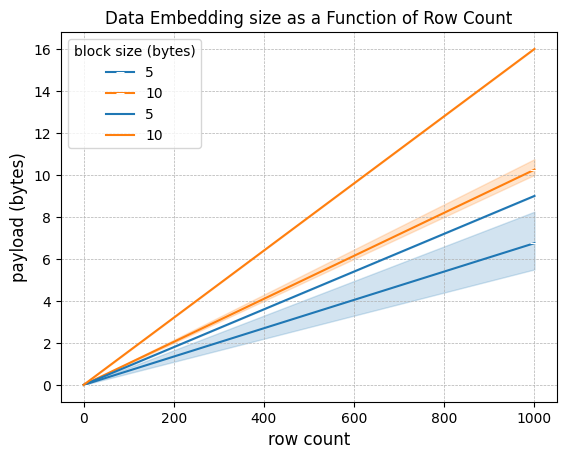

In [13]:
ddf= pl.DataFrame(results)
#ddf = ddf.filter(pl.col("total") > 1000)

ddf = ddf.with_columns(pl.col("bloc_size").cast(pl.String()).alias("bloc"))

ax = sns.lineplot(x="total", y="payload", hue="bloc", marker="_", data=ddf)
ax2 = sns.lineplot(x="total", y="pmax", hue="bloc", c="gray", marker="", data=ddf)

plt.xlabel("row count", fontsize=12)
plt.ylabel("payload (bytes)", fontsize=12)
plt.legend(title="block size (bytes)")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.title("Data Embedding size as a Function of Row Count")


In [6]:
with open("lena.png","rb") as file:
    data = file.read()

len(data)

1005

In [7]:
from PIL import Image
from io import BytesIO
from IPython.display import display

In [86]:
a = BitPool(bit_per_row=2, block_size=5, parity_size=5)
sdf, count = a._encode(df, data)

print(count)

3592


In [50]:
a.get_packet_size() * 2714 * 8

564512

In [38]:
import matplotlib.pyplot as plt
import altair as alt

In [61]:
6 * len(df) / 100

37381.62

In [63]:
len(df) / 37381

16.666943099435542

Country,Age,Gender,Cholesterol_Level,Blood_Pressure,Smoking_History,Alcohol_Consumption,Physical_Activity,Obesity,Diabetes,Family_History,Stress_Levels,Dietary_Habits,Heart_Attack_History,Chest_Pain,Exercise_Induced_Angina,Resting_ECG,Max_Heart_Rate_Achieved,Thalassemia,HDL_Cholesterol,LDL_Cholesterol,Triglycerides,Heart_Disease_Risk,Medication_Adherence,Urbanization_Level,Air_Pollution_Exposure,Access_To_Healthcare,Education_Level,Income_Level,Heart_Attack_Outcome
str,i64,str,f64,f64,str,f64,str,str,str,str,f64,str,str,str,str,str,i64,str,f64,f64,f64,str,str,str,f64,str,str,str,str
"""United Kingdom""",41,"""Male""",159.435891,139.07524,"""Current""",0.396513,"""Moderate""","""Yes""","""No""","""No""",7.587527,"""Unhealthy""","""No""","""No""","""Yes""","""Abnormal""",77,"""Fixed Defect""",39.31504,116.952875,464.515756,"""High""","""No""","""Rural""",77.879085,"""Good""","""Primary""","""Low""","""Died"""
"""South Africa""",83,"""Male""",156.87355,112.141974,"""Former""",5.700072,"""Active""","""No""","""No""","""No""",2.759379,"""Moderate""","""Yes""","""No""","""No""","""Normal""",119,"""Fixed Defect""",54.572051,137.491595,262.677114,"""Medium""","""Yes""","""Rural""",96.631337,"""Poor""","""Tertiary""","""High""","""Survived"""
"""China""",50,"""Male""",246.722558,102.626767,"""Current""",9.087827,"""Sedentary""","""Yes""","""Yes""","""Yes""",3.137549,"""Healthy""","""Yes""","""No""","""Yes""","""Abnormal""",85,"""Reversible Defect""",39.049354,194.763097,454.668906,"""Medium""","""Yes""","""Suburban""",42.131201,"""Poor""","""Tertiary""","""Medium""","""Died"""
"""Russia""",40,"""Male""",249.13148,116.990892,"""Current""",4.394202,"""Moderate""","""Yes""","""Yes""","""Yes""",2.086069,"""Moderate""","""Yes""","""No""","""No""","""Abnormal""",148,"""Normal""",35.929851,88.843697,116.512372,"""Medium""","""No""","""Urban""",95.554379,"""Average""","""Secondary""","""Medium""","""Died"""
"""China""",65,"""Male""",284.049931,161.471981,"""Current""",8.728684,"""Active""","""Yes""","""No""","""Yes""",6.969963,"""Moderate""","""No""","""Yes""","""Yes""","""Normal""",67,"""Normal""",22.736056,171.434085,255.946483,"""High""","""Yes""","""Rural""",84.362767,"""Good""","""Primary""","""Low""","""Survived"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Egypt""",33,"""Male""",284.075687,172.783067,"""Never""",1.395931,"""Sedentary""","""Yes""","""Yes""","""No""",2.419354,"""Healthy""","""Yes""","""No""","""Yes""","""Abnormal""",61,"""Fixed Defect""",48.124838,144.698571,115.652135,"""High""","""No""","""Rural""",36.058334,"""Average""","""Tertiary""","""High""","""Died"""
"""Australia""",67,"""Female""",159.784513,86.824365,"""Never""",5.032523,"""Sedentary""","""No""","""No""","""Yes""",7.704252,"""Healthy""","""Yes""","""No""","""Yes""","""Abnormal""",157,"""Reversible Defect""",66.511509,187.156985,140.357862,"""Low""","""No""","""Rural""",12.39987,"""Average""","""Secondary""","""High""","""Died"""
"""Turkey""",72,"""Male""",197.679337,154.502756,"""Current""",7.12512,"""Moderate""","""Yes""","""No""","""No""",8.556269,"""Moderate""","""No""","""No""","""Yes""","""Normal""",68,"""Fixed Defect""",96.451441,110.020969,281.666742,"""High""","""No""","""Rural""",16.754542,"""Average""","""None""","""High""","""Died"""


In [ ]:
mdf = sdf.clone()

percent = 4
count = int(len(mdf) * (percent / 100))
index = random.sample(range(len(mdf)), count)

fdf = mdf.with_row_index().filter(~pl.col("index").is_in(index)).drop("index")

data2= a._decode(fdf)

image_data = BytesIO(data2["payload"])
# Ouvrir l'image avec Pillow
image = Image.open(image_data)
# Afficher l'image
display(image)

In [79]:
5 * len(mdf) / 100

31151.35

In [81]:
len(mdf) / 31151

20.00022471188726

In [82]:
a.get_packet_size()

26

In [83]:
20/8

2.5

In [133]:
a.get_packet_size()

21

In [38]:
df = ddf.filter(pl.col("bloc_size") == "5")

X = df["total"][50:].to_numpy().reshape(-1,1)
y = df["payload"][50:].to_numpy()


model = LinearRegression()
model.fit(X,y)

model.score(X,y)

a = model.coef_[0]
b = model.intercept_

print(a,b)


0.009071152209700253 0.6953170125900474


# Tolerance au mutation

In [41]:
1000*0.01

10.0

In [46]:
df.filter(pl.col("total") == 1700)

total,payload,bloc_size
i64,i64,str
1700,21,"""5"""
1700,18,"""5"""
1700,19,"""5"""
1700,20,"""5"""


In [5]:
df_encoded = df.to_pandas()


In [80]:
def create_error(mdf, percent):
    
    df_encoded = mdf.to_pandas().copy()
 
    count = len(df_encoded) * percent // 100
    if count == 0:
        return mdf

    count = int(count)
    idx = random.sample(range(len(df_encoded)), k = count)
    df_encoded.iloc[idx, 0] = None
    return pl.from_pandas(df_encoded)




t = pl.DataFrame({"a": range(10), "b": range(10)})

create_error(t, 50.0)

a,b
f64,i64
0.0,0
null,1
null,2
null,3
null,4
null,5
6.0,6
7.0,7
8.0,8


In [97]:
def create_deletion(mdf, percent):
    df_encoded = mdf.to_pandas()
    size = len(df_encoded)
    count = int(percent * size / 100) 
    
    index = df_encoded.sample(count).index
    df_encoded = df_encoded.drop(index)

    return pl.from_pandas(df_encoded)


    

    

In [159]:
import numpy as np

np.arange(0, 2, 0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9])

In [261]:
df = pl.read_csv("heart_attack_predictions.csv")
df = df.head(10000)
payload = b"se"

results = []
for p in tqdm(range(1,30,1)):
    for b in [5, 25]:
        a = BitPool(bit_per_row=1, parity_size=p, block_size=b)
        sdf = a.encode(df, payload)
        max_error = 0.0
        error  = 0.0
        while True:
            sdf = create_error(sdf, error)
            if a.decode(sdf) == payload:
                max_error = error
                error += 0.1
            else:
                break
        
        results.append({"p": p, "b": b, "error": max_error})


results = pl.DataFrame(results)


100%|█████████████████████████████████████████████████████████| 29/29 [02:58<00:00,  6.16s/it]


Text(0.5, 1.0, 'Row error tolerance based on correction code length')

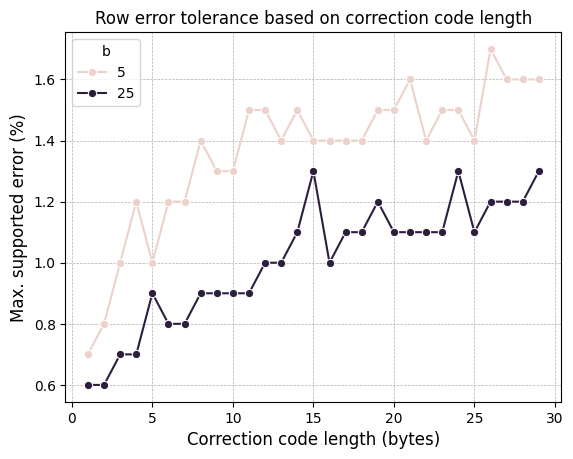

In [262]:
gdf = pl.DataFrame(results)
gdf.write_parquet("error.parquet")


sns.lineplot(x="p", y="error", hue="b", marker="o", data = gdf.to_pandas())

plt.xlabel("Correction code length (bytes)", fontsize=12)
plt.ylabel("Max. supported error (%)", fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.title("Row error tolerance based on correction code length")



In [47]:
df = pl.read_csv("heart_attack_predictions.csv")
df = df.head(5000)
payload = b'secret'
ntry = 5
results = []

for b in [5,25]:
    for parity in tqdm(range(1, 20, 5)):
    
        for _ in range(ntry):
            a = BitPool(bit_per_row=1, parity_size=parity, block_size=b)
            edf = a.encode(df,payload)

            for error in range(0, 100, 20):
                
                edf_error = create_error(edf, error)
                if a.decode(mdf) == payload:
                    max_error = error
                else:
                    break
        
            results.append(
                {
                    "parity": parity,
                    "error" : max_error,
                    "block": b
                }
            )





  0%|                                                                   | 0/5 [00:00<?, ?it/s]

  0%|                                                                   | 0/5 [00:00<?, ?it/s]

  0%|                                                                   | 0/5 [00:00<?, ?it/s]

  0%|                                                                   | 0/5 [00:00<?, ?it/s]

  0%|                                                                   | 0/5 [00:00<?, ?it/s]

  0%|                                                                   | 0/5 [00:00<?, ?it/s]

  0%|                                                                   | 0/5 [00:00<?, ?it/s]

  0%|                                                                   | 0/5 [00:00<?, ?it/s]

  0%|                                                                   | 0/5 [00:00<?, ?it/s]

  0%|                                                                   | 0/5 [00:00<?, ?it/s]

  0%|                                   

Text(0.5, 1.0, 'Row error tolerance based on correction code length')

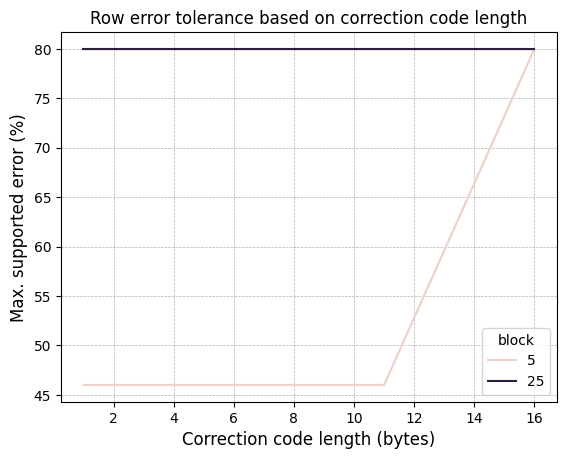

In [48]:
gdf = pl.DataFrame(results)
gdf.write_parquet("error.parquet")


sns.lineplot(x="parity", y="error", hue="block", data = gdf.to_pandas())

plt.xlabel("Correction code length (bytes)", fontsize=12)
plt.ylabel("Max. supported error (%)", fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.title("Row error tolerance based on correction code length")


